In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from tqdm import tqdm
torch.manual_seed(42)
import random
from abc import ABC, abstractmethod
random.seed(0)
np.random.seed(0)

In [15]:
class Solver(ABC, nn.Module):
    def __init__(self):
        super(Solver, self).__init__()

    @abstractmethod
    def step(self, *args, **kwargs):
        pass

class EulerSolver(Solver):
    def __init__(self):
        super(EulerSolver, self).__init__()
    
    def step(self, dynamics_fn, p0, q0, dt):
        dp_dt, dq_dt = dynamics_fn(p0, q0)
        p = p0 + dt * dp_dt
        q = q0 + dt * dq_dt
        return p, q
    
class LeapFrogSolver(Solver):
    def __init__(self):
        super(LeapFrogSolver, self).__init__()
        
    def step(self, dynamics_fn, p0, q0, dt):
        p_half = p0 + 0.5 * dt * dynamics_fn(p0, q0)[0]
        q = q0 + dt * dynamics_fn(p_half, q0)[1]
        p = p_half + 0.5 * dt * dynamics_fn(p_half, q)[0]
        return p, q
    
    
class RK2Solver(Solver):
    def __init__(self):
        super(RK2Solver, self).__init__()
        
    def step(self, dynamics_fn, p0, q0, dt):
        p1, q1 = dynamics_fn(p0, q0)
        p2, q2 = dynamics_fn(p0 + 0.5 * dt * p1, q0 + 0.5 * dt * q1)
        p = p0 + dt * (p1 + p2) / 2 
        q = q0 + dt * (q1 + q2) / 2
        return p, q
    
class SVSolver(Solver):
    
    def __init__(self):
        super(SVSolver, self).__init__()
        
    def step(self, dynamics_fn, p0, q0, dt, iterations = 10, p_init = None, q_init = None):
        if p_init:
            p_half = (p_init + p0)/2
        else:
            p_half = p0
        for _ in range(iterations):
            p_half = p0 + 0.5 * dt * dynamics_fn(p_half, q0)[0]
        q1 = q0 + 0.5 * dt * dynamics_fn(p_half, q0)[1]
        if q_init:
            q2 = (q_init + q1)/2
        else:
            q2 = q1
        for _ in range(iterations):
            q2 = q1 + 0.5 * dt * dynamics_fn(p_half, q2)[1]
        p1 = p_half + 0.5 * dt * dynamics_fn(p_half, q2)[0]
        return p1, q2
    
class PCSolver(Solver):
    
    def __init__(self):
        super(PCSolver, self).__init__()
        
    def step(self, dynamics_fn, p0, q0, dt, implicit, explicit, iterations):
        p, q = explicit.step(dynamics_fn, p0, q0, dt)
        p, q = implicit.step(dynamics_fn, p0 = p0, q0 = q0, dt = dt, iterations = iterations, p_init = p, q_init = q)
        return p, q

In [16]:
class System(ABC, nn.Module):
    def __init__(self, p_min, p_max, q_min, q_max):
        super(System, self).__init__()
        self.p_min = p_min
        self.p_max = p_max
        self.q_min = q_min
        self.q_max = q_max

    @abstractmethod
    def h(self, p, q):
        pass

    @abstractmethod
    def dynamics(self, p, q):
        pass

    def generate_samples(self, num, solver, T, dt, **kwargs):
        dataset = torch.zeros(num, T, 3)
        for i in tqdm(range(num)):
            # p0 = torch.rand(1)*(self.p_max-self.p_min) + self.p_min
            # q0 = torch.rand(1)*(self.q_max-self.q_min) + self.q_min
            y0 = torch.rand(2)*3-1
            radius = torch.rand(1)*0.9 + 0.1
            y0 = y0 / torch.sqrt((y0**2).sum()) * radius
            p0 = y0[0]
            q0 = y0[1]
            dataset[i, 0, 0] = p0
            dataset[i, 0, 1] = q0
            dataset[i, 0, 2] = self.h(p0, q0)
            p = p0
            q = q0
            for j in range(1, T):
                p, q = solver.step(self.dynamics, p, q, dt, **kwargs)
                dataset[i, j, 0] = p
                dataset[i, j, 1] = q
                dataset[i, j, 2] = self.h(p, q)
        return dataset

class MassSpring(System):
    def __init__(self, p_min, p_max, q_min, q_max):
        super(MassSpring, self).__init__(p_min, p_max, q_min, q_max)
        
    def h(self, p, q):
        return p**2 + q**2
    
    def dynamics(self, p, q):
        return -2 * q, 2 * p
    
class PendulumSystem(System):
    def __init__(self, p_min, p_max, q_min, q_max):
        super(PendulumSystem, self).__init__(p_min, p_max, q_min, q_max)
        
    def h(self, p, q):
        return p**2 + 3*(1-torch.cos(q))
    
    def dynamics(self, p, q):
        return -3*torch.sin(q), 2*p
    
class TaoSystem(System):
    def __init__(self, p_min, p_max, q_min, q_max):
        super(TaoSystem, self).__init__(p_min, p_max, q_min, q_max)
        
    def h(self, p, q):
        return 0.5 * (p**2 + 1) * (q**2 + 1)
    
    def dynamics(self, p, q):
        return -q*(p**2 + 1), p*(q**2 + 1)

In [ ]:
ms = MassSpring(-1, 1, -1, 1)
implicit = SVSolver()
explicit = RK2Solver()
solver_pc = PCSolver()
# euler = EulerSolver()
# lf = LeapFrogSolver()
num_steps = 2
dt = 0.001

train = ms.generate_samples(1000, solver_pc, int(num_steps/dt), dt, implicit = implicit, explicit = explicit, iterations = 10)
val = ms.generate_samples(200, solver_pc, int(num_steps/dt), dt, implicit = implicit, explicit = explicit, iterations = 10)
test = ms.generate_samples(200, solver_pc, int(num_steps/dt), dt, implicit = implicit, explicit = explicit, iterations = 10)

 40%|████████████████▊                         | 80/200 [01:10<01:44,  1.15it/s]

In [6]:
train[:5, :5, 0]

tensor([[ 0.3051,  0.3045,  0.3038,  0.3032,  0.3025],
        [ 0.6382,  0.6380,  0.6379,  0.6378,  0.6377],
        [-0.1557, -0.1576, -0.1595, -0.1613, -0.1632],
        [-0.2003, -0.2015, -0.2027, -0.2039, -0.2051],
        [ 0.7028,  0.7021,  0.7015,  0.7009,  0.7003]])

In [269]:
data = "mass_spring"

In [270]:
filepath = "data/"+data+"/version_3/train.pt"
torch.save(train, filepath)

filepath = "data/"+data+"/version_3/val.pt"
torch.save(val, filepath)

filepath = "data/"+data+"/version_3/test.pt"
torch.save(test, filepath)

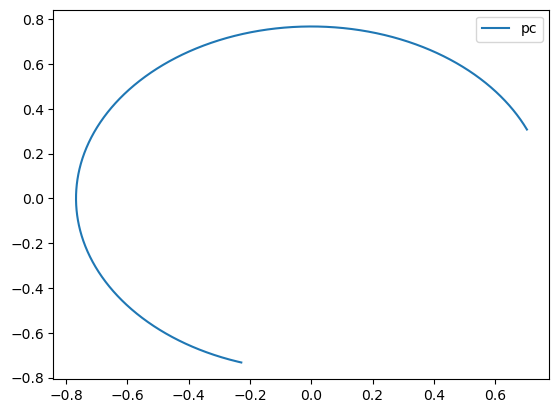

In [13]:
plt.plot(train[4, :, 0], train[4, :, 1], label = "pc")
# plt.plot(train_euler[0, :, 0], train_euler[0, :, 1], label = "euler")
# plt.plot(train_lf[0, :, 0], train_lf[0, :, 1], label = "lf")
# plt.plot(train_explicit[0, :, 0], train_explicit[0, :, 1], label = "explicit")
# plt.plot(train_implicit[0, :, 0], train_implicit[0, :, 1], label = "implicit")
plt.legend()

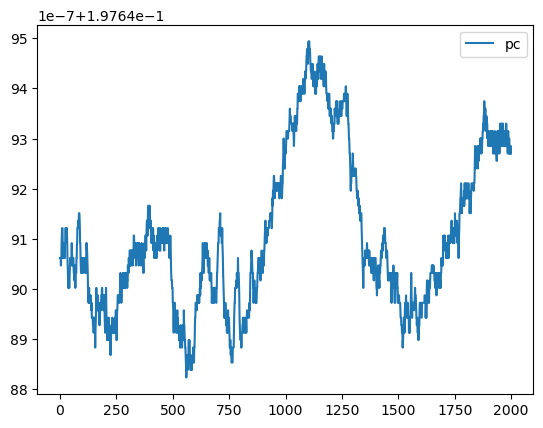

In [9]:
plt.plot(train[0, :, 2], label = "pc")
# plt.plot(train_euler[0, :, 2], label = "euler")
# plt.plot(train_lf[0, :, 2], label = "lf")
# plt.plot(train_explicit[0, :, 2], label = "explicit")
# plt.plot(train[0, :, 2], label = "implicit")
plt.legend()

In [10]:
train[0, :, 2]

tensor([0.1976, 0.1976, 0.1976,  ..., 0.1976, 0.1976, 0.1976])